In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
747/4825

0.15481865284974095

In [6]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [11]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
113,ham,I'm ok wif it cos i like 2 try new things. But...,0
3369,ham,"Hey elaine, is today's meeting still on?",0
936,ham,Then dun wear jeans lor...,0
531,spam,PRIVATE! Your 2003 Account Statement for 07815...,1
5381,spam,You have 1 new message. Call 0207-083-6089,1


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [13]:
X_train.head(4)

3189    This is the 2nd time we have tried 2 contact u...
1687    todays vodafone numbers ending with 0089(my la...
5562    Ok lor... Sony ericsson salesman... I ask shuh...
3016    &lt;#&gt;  mins but i had to stop somewhere fi...
Name: Message, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "buddy, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843582  , -0.51349235, -0.88868284, ..., -0.7477336 ,
        -0.75324166,  0.9197023 ],
       [-0.87199825, -0.50528634, -0.9443545 , ..., -0.8583778 ,
        -0.71726066,  0.88080364]], dtype=float32)>

In [16]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.99092054]], dtype=float32)

In [18]:
cosine_similarity([e[0]],[e[3]])

array([[0.847021]], dtype=float32)

In [19]:
cosine_similarity([e[3]],[e[4]])

array([[0.9871164]], dtype=float32)

In [20]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [22]:
len(X_train)

1120

<h4>Train the model</h4>

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [24]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 26s 503ms/step - loss: 0.6630 - accuracy: 0.6036 - precision: 0.5986 - recall: 0.6286
Epoch 2/10
35/35 [==============================] - 19s 554ms/step - loss: 0.5238 - accuracy: 0.8018 - precision: 0.7955 - recall: 0.8125
Epoch 3/10
35/35 [==============================] - 18s 505ms/step - loss: 0.4499 - accuracy: 0.8473 - precision: 0.8236 - recall: 0.8839
Epoch 4/10
35/35 [==============================] - 18s 500ms/step - loss: 0.4008 - accuracy: 0.8625 - precision: 0.8537 - recall: 0.8750
Epoch 5/10
35/35 [==============================] - 17s 499ms/step - loss: 0.3683 - accuracy: 0.8687 - precision: 0.8506 - recall: 0.8946
Epoch 6/10
35/35 [==============================] - 18s 502ms/step - loss: 0.3421 - accuracy: 0.8848 - precision: 0.8722 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 18s 501ms/step - loss: 0.3227 - accuracy: 0.8902 - precision: 0.8735 - recall: 0.9125
Epoch 8/10
35/35 [================

In [25]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 8s 492ms/step - loss: 0.2784 - accuracy: 0.9171 - precision: 0.9149 - recall: 0.9198


[0.27839553356170654,
 0.9171122908592224,
 0.914893627166748,
 0.9197860956192017]

In [26]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 6s 511ms/step


In [27]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[171,  16],
       [ 15, 172]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

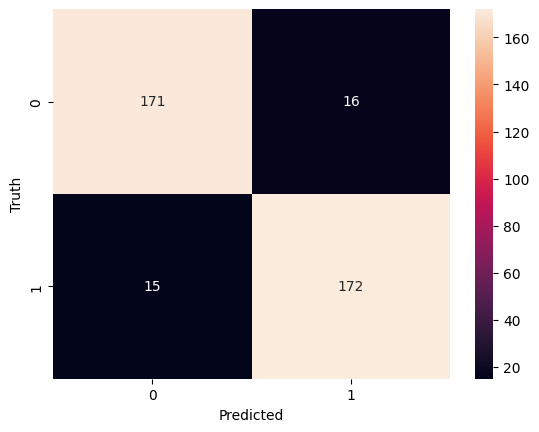

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       187
           1       0.91      0.92      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



<h4>Inference</h4>

In [32]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
results = model.predict(reviews)

1/1 [==============================] - 0s 98ms/step


In [33]:
for i in results:
    print("Spam" if i[0]>0.5 else "Ham")

Spam
Spam
Spam
Ham
Ham
